In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import Counter

Mounted at /content/drive


In [2]:
base_path = '/content/drive/MyDrive/archive/chest_xray/chest_xray'

print("Dataset Path")
print("" * 40)
print(f"Dataset path: {base_path}")
if os.path.exists(base_path):
    print(" Dataset found!")
    print("\n Folder structure:")
    for item in os.listdir(base_path):
        item_path = os.path.join(base_path, item)
        if os.path.isdir(item_path):
            print(f"{item}/")
            for sub_item in os.listdir(item_path):
                print(f"{sub_item}/")
else:
    print(" Dataset not found!")
    print("Available paths in archive:")
    archive_path = '/content/drive/MyDrive/archive'
    if os.path.exists(archive_path):
        for item in os.listdir(archive_path):
            print(f"{item}")

Dataset Path

Dataset path: /content/drive/MyDrive/archive/chest_xray/chest_xray
 Dataset found!

 Folder structure:
train/
.DS_Store/
PNEUMONIA/
NORMAL/
val/
.DS_Store/
NORMAL/
PNEUMONIA/
test/
.DS_Store/
PNEUMONIA/
NORMAL/


In [3]:
def count_images_in_folder(folder_path, class_name):
    """Count images in a specific class folder"""
    class_path = os.path.join(folder_path, class_name)
    if os.path.exists(class_path):
        image_files = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        count = len(image_files)
        print(f"  {class_name}: {count} images")
        return count
    else:
        print(f"  {class_name}: Folder not found")
        return 0
print("Image counting function defined!")

Image counting function defined!


In [5]:
import os, shutil, random

# Paths
base_path = '/content/drive/MyDrive/archive/chest_xray/chest_xray'
train_normal = os.path.join(base_path, 'train', 'NORMAL')
train_pneumonia = os.path.join(base_path, 'train', 'PNEUMONIA')
val_normal = os.path.join(base_path, 'val', 'NORMAL')
val_pneumonia = os.path.join(base_path, 'val', 'PNEUMONIA')

# Ensure validation dirs exist
os.makedirs(val_normal, exist_ok=True)
os.makedirs(val_pneumonia, exist_ok=True)

def move_images(src, dst, target_count):
    """Move random images from src to dst until dst has target_count images."""
    current_count = len(os.listdir(dst))
    needed = target_count - current_count
    if needed <= 0:
        print(f"{dst} already has {current_count} images (>= {target_count}). Skipping.")
        return

    candidates = os.listdir(src)
    to_move = random.sample(candidates, needed)
    for f in to_move:
        shutil.move(os.path.join(src, f), os.path.join(dst, f))
    print(f"Moved {needed} images from {src} → {dst} (now has {len(os.listdir(dst))})")

# Move enough images to reach 100 NORMAL and 120 PNEUMONIA in val
move_images(train_normal, val_normal, 100)
move_images(train_pneumonia, val_pneumonia, 120)

print("Validation set resized successfully!")


/content/drive/MyDrive/archive/chest_xray/chest_xray/val/NORMAL already has 100 images (>= 100). Skipping.
/content/drive/MyDrive/archive/chest_xray/chest_xray/val/PNEUMONIA already has 120 images (>= 120). Skipping.
Validation set resized successfully!


In [6]:
print("Counting Images in Dataset")
print("" * 40)
splits = ['train', 'test', 'val']
results = {}
for split in splits:
    split_path = os.path.join(base_path, split)
    print(f"\nCounting {split.upper()} images:")
    normal_count = count_images_in_folder(split_path, 'NORMAL')
    pneumonia_count = count_images_in_folder(split_path, 'PNEUMONIA')
    results[split] = {
        'normal': normal_count,
        'pneumonia': pneumonia_count,
        'total': normal_count + pneumonia_count
    }
total_normal = sum([results[split]['normal'] for split in splits])
total_pneumonia = sum([results[split]['pneumonia'] for split in splits])
total_images = total_normal + total_pneumonia

print(f"\nOVERALL TOTALS:")
print(f"Normal: {total_normal:,}")
print(f"Pneumonia: {total_pneumonia:,}")
print(f"Total: {total_images:,}")

if total_images > 0:
    print(f"Normal percentage: {total_normal/total_images*100:.1f}%")
    print(f"Pneumonia percentage: {total_pneumonia/total_images*100:.1f}%")
    print(f"Class imbalance ratio: 1:{total_pneumonia/total_normal:.1f}")

Counting Images in Dataset


Counting TRAIN images:
  NORMAL: 1250 images
  PNEUMONIA: 3764 images

Counting TEST images:
  NORMAL: 234 images
  PNEUMONIA: 392 images

Counting VAL images:
  NORMAL: 99 images
  PNEUMONIA: 119 images

OVERALL TOTALS:
Normal: 1,583
Pneumonia: 4,275
Total: 5,858
Normal percentage: 27.0%
Pneumonia percentage: 73.0%
Class imbalance ratio: 1:2.7


In [7]:
print("STEP 5: Creating Summary Table")
print("" * 40)
summary_data = {
    'Split': ['Train', 'Test', 'Validation', 'Total'],
    'Normal': [
        results['train']['normal'],
        results['test']['normal'],
        results['val']['normal'],
        total_normal
    ],
    'Pneumonia': [
        results['train']['pneumonia'],
        results['test']['pneumonia'],
        results['val']['pneumonia'],
        total_pneumonia
    ],
    'Total': [
        results['train']['total'],
        results['test']['total'],
        results['val']['total'],
        total_images
    ]
}
df_summary = pd.DataFrame(summary_data)
print("Dataset Summary Table:")
print(df_summary.to_string(index=False))
df_summary.to_csv('dataset_summary.csv', index=False)
print("\nSummary saved as 'dataset_summary.csv'")

STEP 5: Creating Summary Table

Dataset Summary Table:
     Split  Normal  Pneumonia  Total
     Train    1250       3764   5014
      Test     234        392    626
Validation      99        119    218
     Total    1583       4275   5858

Summary saved as 'dataset_summary.csv'


Pie Chart



Text(0.5, 1.0, 'Overall Class Distribution')

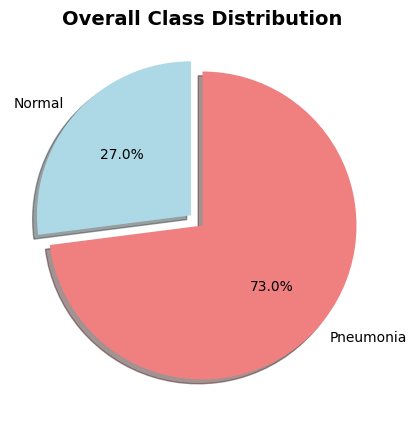

In [8]:
print("Pie Chart")
print("" * 40)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
labels = ['Normal', 'Pneumonia']
sizes = [total_normal, total_pneumonia]
colors = ['lightblue', 'lightcoral']
explode = (0.1, 0)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors,
        explode=explode, shadow=True, startangle=90)
plt.title('Overall Class Distribution', fontweight='bold', fontsize=14)

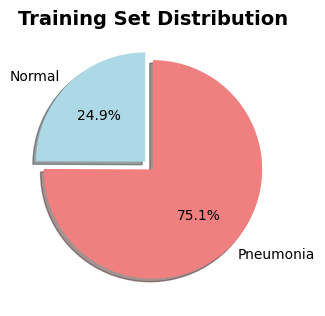

In [9]:
plt.subplot(1, 2, 2)
train_sizes = [results['train']['normal'], results['train']['pneumonia']]
plt.pie(train_sizes, labels=labels, autopct='%1.1f%%', colors=colors,
        explode=explode, shadow=True, startangle=90)
plt.title('Training Set Distribution', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

Bar Charts



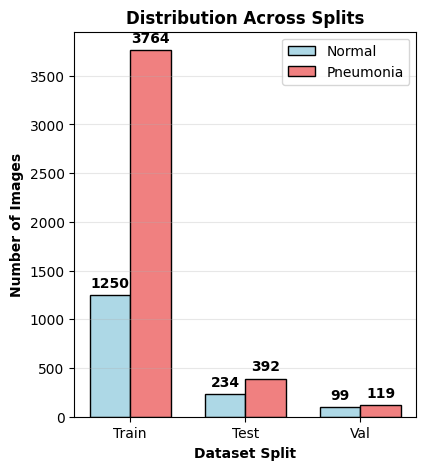

In [10]:
print("Bar Charts")
print("" * 40)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
split_names = ['Train', 'Test', 'Val']
normal_counts = [results['train']['normal'], results['test']['normal'], results['val']['normal']]
pneumonia_counts = [results['train']['pneumonia'], results['test']['pneumonia'], results['val']['pneumonia']]
x = np.arange(len(split_names))
width = 0.35
bars1 = plt.bar(x - width/2, normal_counts, width, label='Normal', color='lightblue', edgecolor='black')
bars2 = plt.bar(x + width/2, pneumonia_counts, width, label='Pneumonia', color='lightcoral', edgecolor='black')
for bar in bars1:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2., height + 50,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')
for bar in bars2:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2., height + 50,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')
plt.xlabel('Dataset Split', fontweight='bold')
plt.ylabel('Number of Images', fontweight='bold')
plt.title('Distribution Across Splits', fontweight='bold')
plt.xticks(x, split_names)
plt.legend()
plt.grid(axis='y', alpha=0.3)

In [11]:
def load_sample_images(base_path, num_samples=3):
    """Load sample images from each class"""
    samples = {'NORMAL': [], 'PNEUMONIA': []}
    train_path = os.path.join(base_path, 'train')
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_path = os.path.join(train_path, class_name)
        print(f"Loading {class_name} samples from: {class_path}")
        if os.path.exists(class_path):
            image_files = [f for f in os.listdir(class_path)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            for i in range(min(num_samples, len(image_files))):
                img_path = os.path.join(class_path, image_files[i])
                try:
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img_resized = cv2.resize(img, (256, 256))
                        samples[class_name].append(img_resized)
                        print(f" Loaded {class_name} sample {i+1}")
                    else:
                        pil_img = Image.open(img_path).convert('L')
                        img_array = np.array(pil_img)
                        img_resized = cv2.resize(img_array, (256, 256))
                        samples[class_name].append(img_resized)
                        print(f" Loaded {class_name} sample {i+1} with PIL")
                except Exception as e:
                    print(f"Error loading {class_name} sample {i+1}: {e}")
        else:
            print(f"Path not found: {class_path}")

    return samples

print("Sample image loading function defined!")

Sample image loading function defined!


Loading and Displaying Sample Images

Loading NORMAL samples from: /content/drive/MyDrive/archive/chest_xray/chest_xray/train/NORMAL
 Loaded NORMAL sample 1
 Loaded NORMAL sample 2
 Loaded NORMAL sample 3
Loading PNEUMONIA samples from: /content/drive/MyDrive/archive/chest_xray/chest_xray/train/PNEUMONIA
 Loaded PNEUMONIA sample 1
 Loaded PNEUMONIA sample 2
 Loaded PNEUMONIA sample 3


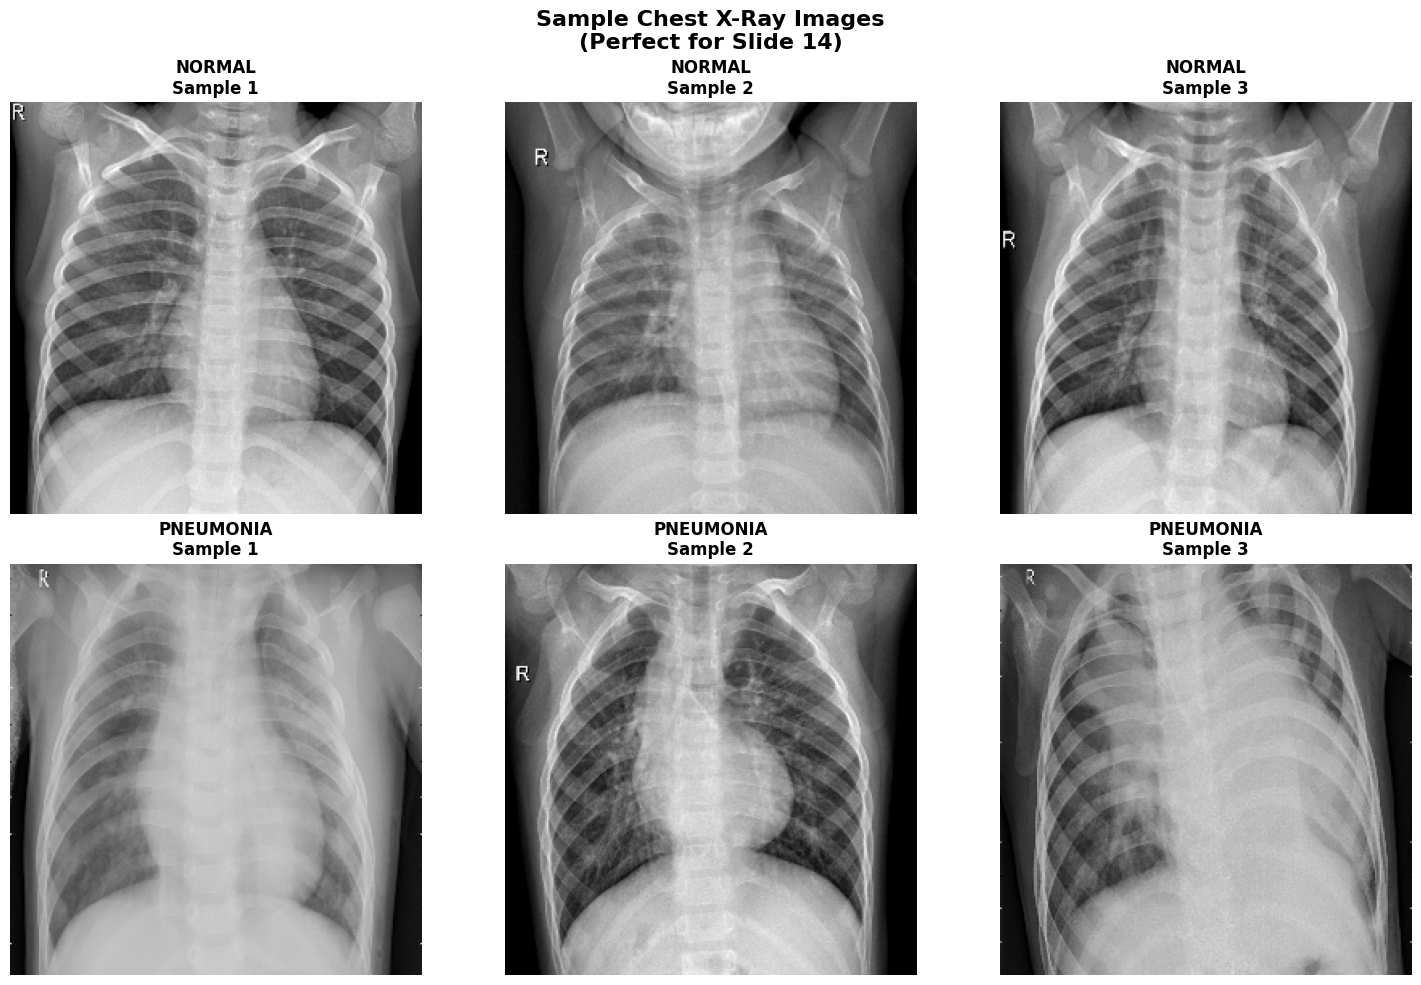

In [13]:
print("Loading and Displaying Sample Images")
print("" * 40)
sample_images = load_sample_images(base_path, num_samples=3)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
classes = ['NORMAL', 'PNEUMONIA']
for row, class_name in enumerate(classes):
    images = sample_images[class_name]
    for col in range(3):
        if col < len(images):
            axes[row, col].imshow(images[col], cmap='gray')
            axes[row, col].set_title(f'{class_name}\nSample {col + 1}',
                                   fontweight='bold', fontsize=12)
            axes[row, col].axis('off')
        else:
            axes[row, col].text(0.5, 0.5, f'{class_name}\nNo Image\nAvailable',
                              ha='center', va='center',
                              transform=axes[row, col].transAxes,
                              fontsize=10, fontweight='bold')
            axes[row, col].axis('off')
plt.suptitle('Sample Chest X-Ray Images\n(Perfect for Slide 14)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [14]:
def analyze_image_dimensions(base_path, sample_size=100):
    """Analyze dimensions of sample images"""
    dimensions = []
    file_sizes = []
    train_path = os.path.join(base_path, 'train')
    print(f"Analyzing dimensions from: {train_path}")
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_path = os.path.join(train_path, class_name)
        if os.path.exists(class_path):
            image_files = [f for f in os.listdir(class_path)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            sample_files = image_files[:sample_size//2]
            print(f"Analyzing {len(sample_files)} {class_name} images...")
            for file in sample_files:
                file_path = os.path.join(class_path, file)
                try:
                    with Image.open(file_path) as img:
                        dimensions.append(img.size)
                    file_size = os.path.getsize(file_path) / (1024 * 1024)
                    file_sizes.append(file_size)
                except Exception as e:
                    continue
    print(f"Analyzed {len(dimensions)} images")
    return dimensions, file_sizes
print("Dimension analysis function defined!")

Dimension analysis function defined!


In [15]:
print("Analyzing Image Dimensions")
print("" * 40)
dimensions, file_sizes = analyze_image_dimensions(base_path, sample_size=100)

if dimensions:
    widths, heights = zip(*dimensions)

    # Print basic statistics
    print(" BASIC STATISTICS:")
    print(f"Number of images analyzed: {len(dimensions)}")
    print(f"Width  - Min: {min(widths):4d}px | Max: {max(widths):4d}px | Mean: {np.mean(widths):6.1f}px")
    print(f"Height - Min: {min(heights):4d}px | Max: {max(heights):4d}px | Mean: {np.mean(heights):6.1f}px")
    print(f"Size   - Min: {min(file_sizes):4.2f}MB | Max: {max(file_sizes):4.2f}MB | Mean: {np.mean(file_sizes):6.2f}MB")

    # Find most common dimensions
    dimension_counts = Counter(dimensions)
    most_common = dimension_counts.most_common(5)
    print(f"\n MOST COMMON DIMENSIONS:")
    for (w, h), count in most_common:
        print(f"  {w}×{h}: {count} images ({count/len(dimensions)*100:.1f}%)")
else:
    print(" No dimensions could be analyzed")

Analyzing Image Dimensions

Analyzing dimensions from: /content/drive/MyDrive/archive/chest_xray/chest_xray/train
Analyzing 50 NORMAL images...
Analyzing 50 PNEUMONIA images...
Analyzed 100 images
 BASIC STATISTICS:
Number of images analyzed: 100
Width  - Min:  666px | Max: 2214px | Mean: 1394.8px
Height - Min:  322px | Max: 1936px | Mean: 1070.4px
Size   - Min: 0.02MB | Max: 1.07MB | Mean:   0.32MB

 MOST COMMON DIMENSIONS:
  1072×648: 2 images (2.0%)
  1176×784: 2 images (2.0%)
  1016×680: 2 images (2.0%)
  1820×1670: 1 images (1.0%)
  1488×1275: 1 images (1.0%)


Creating Dimension Plots


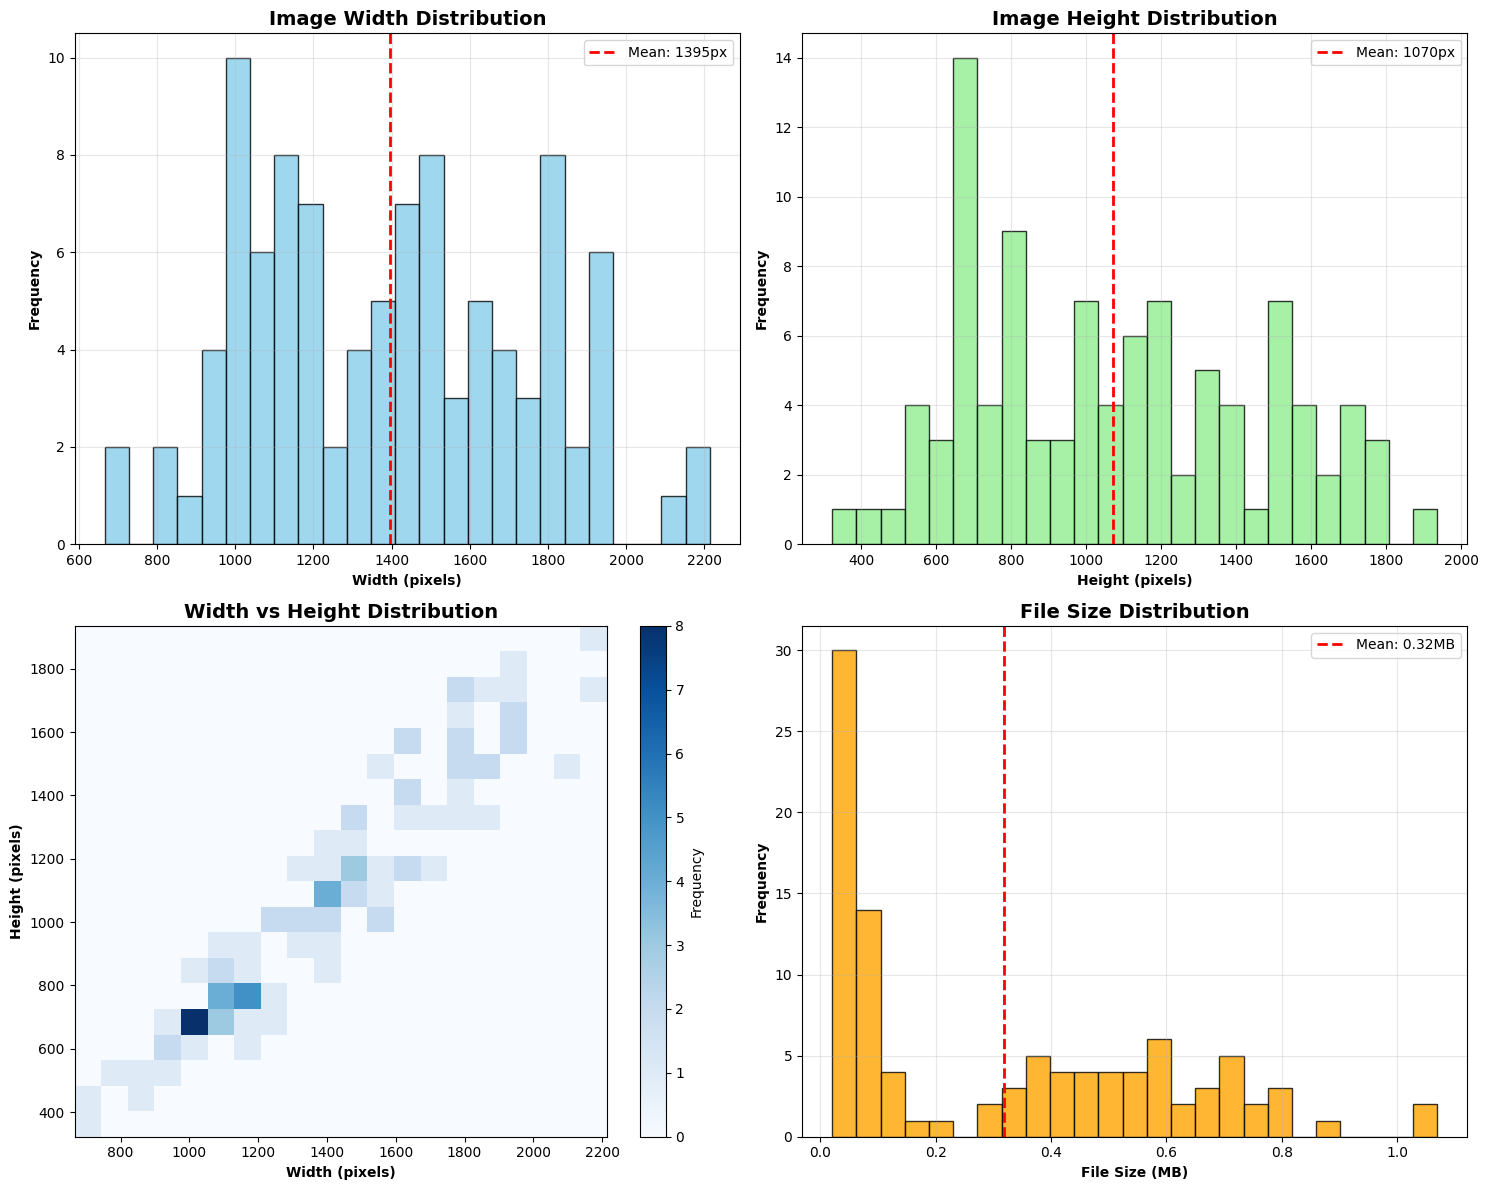

Dimension analysis plots created!


In [16]:
print("Creating Dimension Plots")
print("=" * 40)
if dimensions:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes[0, 0].hist(widths, bins=25, alpha=0.8, color='skyblue', edgecolor='black')
    axes[0, 0].set_xlabel('Width (pixels)', fontweight='bold')
    axes[0, 0].set_ylabel('Frequency', fontweight='bold')
    axes[0, 0].set_title('Image Width Distribution', fontweight='bold', fontsize=14)
    axes[0, 0].axvline(np.mean(widths), color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {np.mean(widths):.0f}px')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    axes[0, 1].hist(heights, bins=25, alpha=0.8, color='lightgreen', edgecolor='black')
    axes[0, 1].set_xlabel('Height (pixels)', fontweight='bold')
    axes[0, 1].set_ylabel('Frequency', fontweight='bold')
    axes[0, 1].set_title('Image Height Distribution', fontweight='bold', fontsize=14)
    axes[0, 1].axvline(np.mean(heights), color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {np.mean(heights):.0f}px')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    h = axes[1, 0].hist2d(widths, heights, bins=20, cmap='Blues')
    axes[1, 0].set_xlabel('Width (pixels)', fontweight='bold')
    axes[1, 0].set_ylabel('Height (pixels)', fontweight='bold')
    axes[1, 0].set_title('Width vs Height Distribution', fontweight='bold', fontsize=14)
    plt.colorbar(h[3], ax=axes[1, 0], label='Frequency')
    axes[1, 1].hist(file_sizes, bins=25, alpha=0.8, color='orange', edgecolor='black')
    axes[1, 1].set_xlabel('File Size (MB)', fontweight='bold')
    axes[1, 1].set_ylabel('Frequency', fontweight='bold')
    axes[1, 1].set_title('File Size Distribution', fontweight='bold', fontsize=14)
    axes[1, 1].axvline(np.mean(file_sizes), color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {np.mean(file_sizes):.2f}MB')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("Dimension analysis plots created!")

In [17]:
print("Pixel Intensity Analysis")
print("" * 40)
def analyze_pixel_intensity(base_path, sample_size=30):
    """Analyze pixel intensity distributions"""
    intensities_normal = []
    intensities_pneumonia = []
    mean_intensities_normal = []
    mean_intensities_pneumonia = []
    train_path = os.path.join(base_path, 'train')
    normal_path = os.path.join(train_path, 'NORMAL')
    if os.path.exists(normal_path):
        files = [f for f in os.listdir(normal_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        files = files[:sample_size]
        print(f"Analyzing {len(files)} normal images...")
        for file in files:
            img_path = os.path.join(normal_path, file)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (256, 256))
                    intensities_normal.extend(img.flatten())
                    mean_intensities_normal.append(np.mean(img))
            except Exception:
                continue
    pneumonia_path = os.path.join(train_path, 'PNEUMONIA')
    if os.path.exists(pneumonia_path):
        files = [f for f in os.listdir(pneumonia_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        files = files[:sample_size]
        print(f"Analyzing {len(files)} pneumonia images...")
        for file in files:
            img_path = os.path.join(pneumonia_path, file)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (256, 256))
                    intensities_pneumonia.extend(img.flatten())
                    mean_intensities_pneumonia.append(np.mean(img))
            except Exception:
                continue
    return (intensities_normal, intensities_pneumonia,
            mean_intensities_normal, mean_intensities_pneumonia)
(intensities_normal, intensities_pneumonia,
 mean_intensities_normal, mean_intensities_pneumonia) = analyze_pixel_intensity(base_path)

print(f"Intensity analysis complete!")
print(f"Normal images: {len(mean_intensities_normal)} analyzed")
print(f"Pneumonia images: {len(mean_intensities_pneumonia)} analyzed")

Pixel Intensity Analysis

Analyzing 30 normal images...
Analyzing 30 pneumonia images...
Intensity analysis complete!
Normal images: 30 analyzed
Pneumonia images: 30 analyzed


Creating Intensity Plots



/tmp/ipython-input-3698560438.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[1, 0].boxplot(data_to_plot, labels=['Normal', 'Pneumonia'],


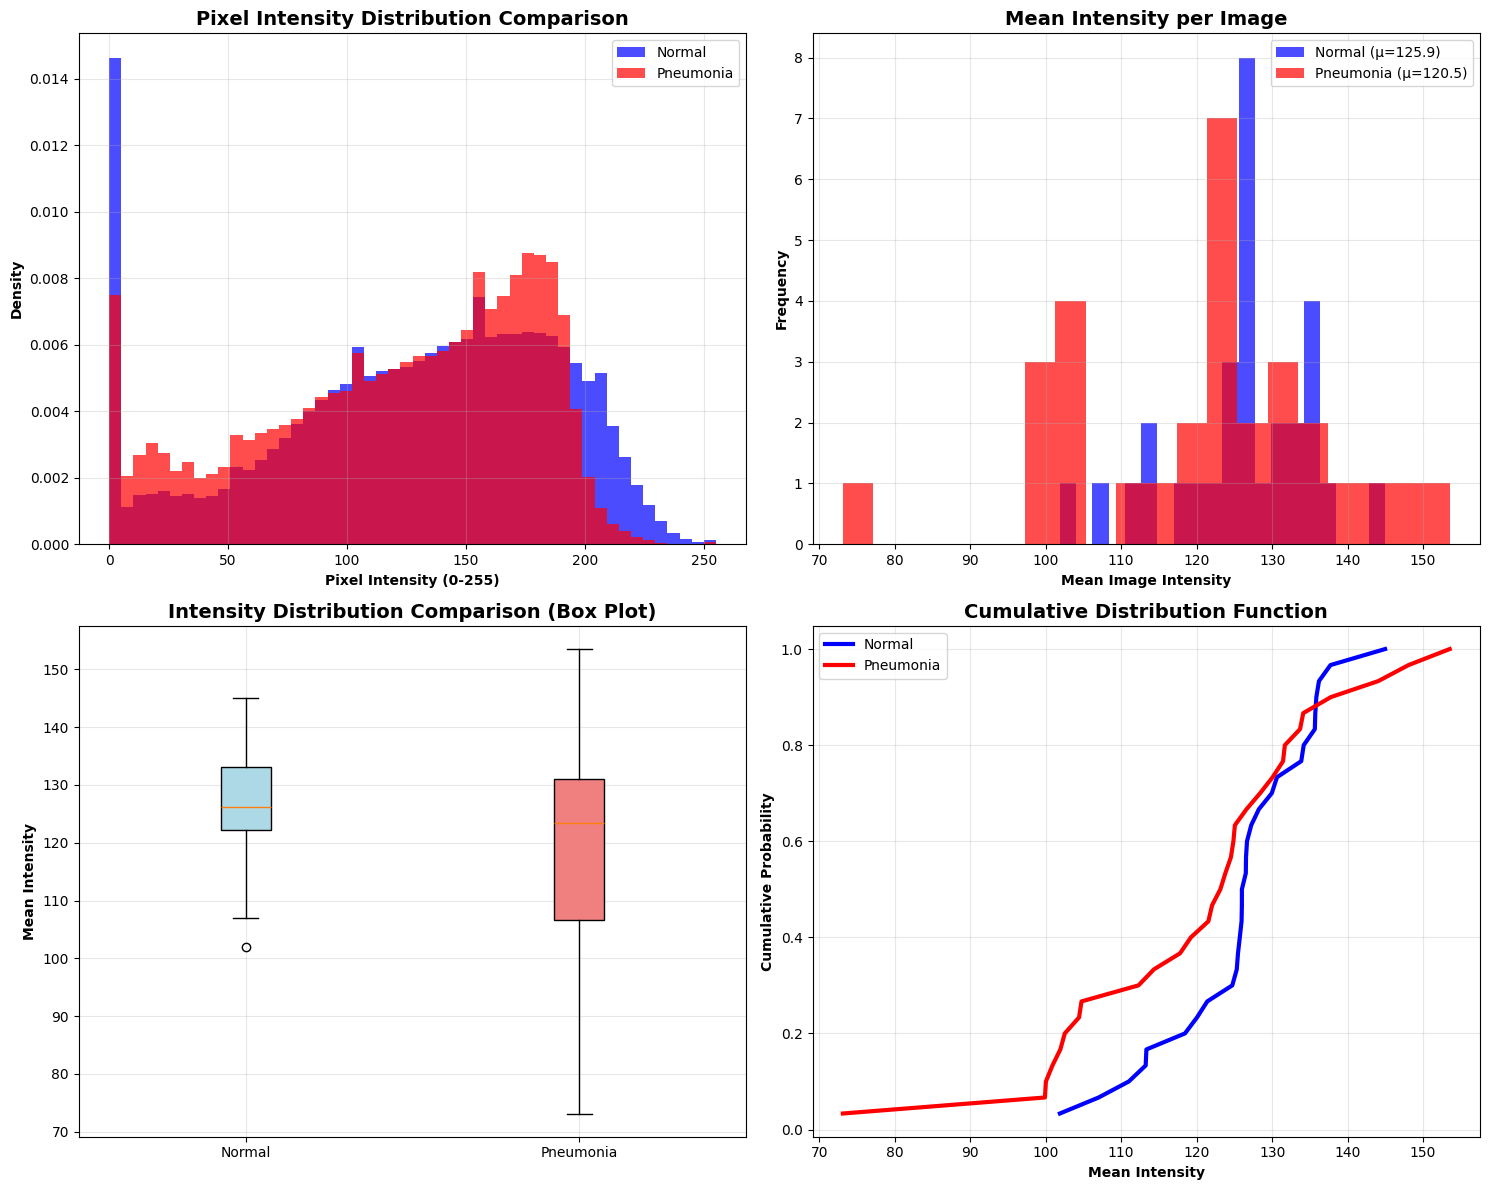

In [18]:
print("Creating Intensity Plots")
print("" * 40)

if intensities_normal and intensities_pneumonia:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes[0, 0].hist(intensities_normal, bins=50, alpha=0.7, color='blue',
                    density=True, label='Normal')
    axes[0, 0].hist(intensities_pneumonia, bins=50, alpha=0.7, color='red',
                    density=True, label='Pneumonia')
    axes[0, 0].set_xlabel('Pixel Intensity (0-255)', fontweight='bold')
    axes[0, 0].set_ylabel('Density', fontweight='bold')
    axes[0, 0].set_title('Pixel Intensity Distribution Comparison', fontweight='bold', fontsize=14)
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    axes[0, 1].hist(mean_intensities_normal, bins=20, alpha=0.7, color='blue',
                    label=f'Normal (μ={np.mean(mean_intensities_normal):.1f})')
    axes[0, 1].hist(mean_intensities_pneumonia, bins=20, alpha=0.7, color='red',
                    label=f'Pneumonia (μ={np.mean(mean_intensities_pneumonia):.1f})')
    axes[0, 1].set_xlabel('Mean Image Intensity', fontweight='bold')
    axes[0, 1].set_ylabel('Frequency', fontweight='bold')
    axes[0, 1].set_title('Mean Intensity per Image', fontweight='bold', fontsize=14)
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    data_to_plot = [mean_intensities_normal, mean_intensities_pneumonia]
    box_plot = axes[1, 0].boxplot(data_to_plot, labels=['Normal', 'Pneumonia'],
                                  patch_artist=True)
    box_plot['boxes'][0].set_facecolor('lightblue')
    box_plot['boxes'][1].set_facecolor('lightcoral')
    axes[1, 0].set_ylabel('Mean Intensity', fontweight='bold')
    axes[1, 0].set_title('Intensity Distribution Comparison (Box Plot)', fontweight='bold', fontsize=14)
    axes[1, 0].grid(alpha=0.3)
    x_normal = np.sort(mean_intensities_normal)
    y_normal = np.arange(1, len(x_normal) + 1) / len(x_normal)
    x_pneumonia = np.sort(mean_intensities_pneumonia)
    y_pneumonia = np.arange(1, len(x_pneumonia) + 1) / len(x_pneumonia)

    axes[1, 1].plot(x_normal, y_normal, color='blue', linewidth=3, label='Normal')
    axes[1, 1].plot(x_pneumonia, y_pneumonia, color='red', linewidth=3, label='Pneumonia')
    axes[1, 1].set_xlabel('Mean Intensity', fontweight='bold')
    axes[1, 1].set_ylabel('Cumulative Probability', fontweight='bold')
    axes[1, 1].set_title('Cumulative Distribution Function', fontweight='bold', fontsize=14)
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [19]:
    print("INTENSITY STATISTICS:")
    print(f"Normal    - Mean: {np.mean(intensities_normal):6.1f} | Std: {np.std(intensities_normal):6.1f}")
    print(f"Pneumonia - Mean: {np.mean(intensities_pneumonia):6.1f} | Std: {np.std(intensities_pneumonia):6.1f}")
    print(f"\nPer-Image Mean Intensities:")
    print(f"Normal    - Mean: {np.mean(mean_intensities_normal):6.1f} | Std: {np.std(mean_intensities_normal):6.1f}")
    print(f"Pneumonia - Mean: {np.mean(mean_intensities_pneumonia):6.1f} | Std: {np.std(mean_intensities_pneumonia):6.1f}")

    # Statistical significance test
    try:
        from scipy import stats
        t_stat, p_value = stats.ttest_ind(mean_intensities_normal, mean_intensities_pneumonia)
        print(f"\n Statistical Test (t-test):")
        print(f"t-statistic: {t_stat:.4f}")
        print(f"p-value: {p_value:.6f}")
        if p_value < 0.05:
            print(" Statistically significant difference in intensities (p < 0.05)")
        else:
            print("No statistically significant difference in intensities (p ≥ 0.05)")
    except ImportError:
        print("Install scipy for statistical tests: !pip install scipy")

    print("Intensity analysis plots created!")

INTENSITY STATISTICS:
Normal    - Mean:  125.9 | Std:   61.9
Pneumonia - Mean:  120.5 | Std:   57.0

Per-Image Mean Intensities:
Normal    - Mean:  125.9 | Std:    9.4
Pneumonia - Mean:  120.5 | Std:   16.7

 Statistical Test (t-test):
t-statistic: 1.4980
p-value: 0.139552
No statistically significant difference in intensities (p ≥ 0.05)
Intensity analysis plots created!


In [20]:
print("Final Summary")
print("" * 40)

print(" EDA ANALYSIS COMPLETE!")
print("\n DATASET SUMMARY FOR YOUR PRESENTATION:")
print(f"• Total Images: {total_images:,}")
print(f"• Training: {results['train']['total']:,} images")
print(f"• Test: {results['test']['total']:,} images")
print(f"• Validation: {results['val']['total']:,} images")
print(f"• Normal: {total_normal:,} ({total_normal/total_images*100:.1f}%)")
print(f"• Pneumonia: {total_pneumonia:,} ({total_pneumonia/total_images*100:.1f}%)")
print(f"• Class Imbalance: 1:{total_pneumonia/total_normal:.1f} (Normal:Pneumonia)")

if dimensions:
    print(f"• Average Image Size: {np.mean(widths):.0f} × {np.mean(heights):.0f} pixels")
    print(f"• Average File Size: {np.mean(file_sizes):.2f} MB")

print("Dataset Overview:")
print(f"""
# Key Statistics:
# Total Images: {total_images:,}
# Normal: {total_normal:,} ({total_normal/total_images*100:.1f}%)
# Pneumonia: {total_pneumonia:,} ({total_pneumonia/total_images*100:.1f}%)
# Class Imbalance: 1:{total_pneumonia/total_normal:.1f}
""")

Final Summary

 EDA ANALYSIS COMPLETE!

 DATASET SUMMARY FOR YOUR PRESENTATION:
• Total Images: 5,858
• Training: 5,014 images
• Test: 626 images
• Validation: 218 images
• Normal: 1,583 (27.0%)
• Pneumonia: 4,275 (73.0%)
• Class Imbalance: 1:2.7 (Normal:Pneumonia)
• Average Image Size: 1395 × 1070 pixels
• Average File Size: 0.32 MB
Dataset Overview:

# Key Statistics:
# Total Images: 5,858
# Normal: 1,583 (27.0%)
# Pneumonia: 4,275 (73.0%)
# Class Imbalance: 1:2.7



In [21]:
print("STEP 5: Creating Summary Table")
print("" * 40)
summary_data = {
    'Split': ['Train', 'Test', 'Validation', 'Total'],
    'Normal': [
        results['train']['normal'],
        results['test']['normal'],
        results['val']['normal'],
        total_normal
    ],
    'Pneumonia': [
        results['train']['pneumonia'],
        results['test']['pneumonia'],
        results['val']['pneumonia'],
        total_pneumonia
    ],
    'Total': [
        results['train']['total'],
        results['test']['total'],
        results['val']['total'],
        total_images
    ]
}
df_summary = pd.DataFrame(summary_data)
print("Dataset Summary Table:")
print(df_summary.to_string(index=False))
df_summary.to_csv('dataset_summary.csv', index=False)
print("\nSummary saved as 'dataset_summary.csv'")


STEP 5: Creating Summary Table

Dataset Summary Table:
     Split  Normal  Pneumonia  Total
     Train    1250       3764   5014
      Test     234        392    626
Validation      99        119    218
     Total    1583       4275   5858

Summary saved as 'dataset_summary.csv'


#### Preprocessing

In [22]:
import os, cv2, random, joblib, gc, numpy as np
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, average_precision_score
)

from skimage.feature import hog, local_binary_pattern
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
BASE_PATH = '/content/drive/MyDrive/archive/chest_xray/chest_xray'
IMG_SIZE = 128
MODEL_DIR = "/content/drive/MyDrive/capstone_models"
os.makedirs(MODEL_DIR, exist_ok=True)


In [23]:
def _load_one_folder(folder, label, img_size=IMG_SIZE):
    items = []
    for fn in os.listdir(folder):
        p = os.path.join(folder, fn)
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32) / 255.0
        items.append((img, label))
    return items

def load_split(split, base=BASE_PATH):
    split_dir = os.path.join(base, split)
    data = []
    data += _load_one_folder(os.path.join(split_dir, "PNEUMONIA"), 1)
    data += _load_one_folder(os.path.join(split_dir, "NORMAL"),    0)
    random.shuffle(data)
    X = np.array([d[0] for d in data], dtype=np.float32)[..., None]  # (N,H,W,1)
    y = np.array([d[1] for d in data], dtype=np.int64)
    return X, y

X_train, y_train = load_split("train")
X_val,   y_val   = load_split("val")
X_test,  y_test  = load_split("test")

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape,   y_val.shape)
print("Test :", X_test.shape,  y_test.shape)


Train: (5014, 128, 128, 1) (5014,)
Val  : (218, 128, 128, 1) (218,)
Test : (626, 128, 128, 1) (626,)


In [24]:
def extract_hog(batch, img_size=IMG_SIZE):
    feats = []
    for im in tqdm(batch, desc="HOG"):
        im2d = im.squeeze()  # (H,W)
        f = hog(im2d,
                orientations=9,
                pixels_per_cell=(8,8),
                cells_per_block=(2,2),
                block_norm='L2-Hys',
                feature_vector=True)
        feats.append(f)
    return np.asarray(feats, dtype=np.float32)

def extract_lbp(batch, P=8, R=1):
    feats = []
    n_bins = P + 2
    for im in tqdm(batch, desc="LBP"):
        im2d = im.squeeze()
        lbp = local_binary_pattern(im2d, P=P, R=R, method='uniform')
        hist, _ = np.histogram(lbp.ravel(),
                               bins=np.arange(0, n_bins + 1),
                               range=(0, n_bins),
                               density=True)
        feats.append(hist.astype(np.float32))
    return np.asarray(feats, dtype=np.float32)

print("Extracting HOG…")
Xtr_hog = extract_hog(X_train); Xv_hog = extract_hog(X_val); Xte_hog = extract_hog(X_test)
print("HOG:", Xtr_hog.shape, Xv_hog.shape, Xte_hog.shape)

print("Extracting LBP…")
Xtr_lbp = extract_lbp(X_train); Xv_lbp = extract_lbp(X_val); Xte_lbp = extract_lbp(X_test)
print("LBP:", Xtr_lbp.shape, Xv_lbp.shape, Xte_lbp.shape)


Extracting HOG…


HOG: 100%|██████████| 626/626 [00:05<00:00, 119.67it/s]


HOG: (5014, 8100) (218, 8100) (626, 8100)
Extracting LBP…


LBP:   0%|          | 0/5014 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
LBP: 100%|██████████| 626/626 [00:02<00:00, 307.75it/s]

LBP: (5014, 10) (218, 10) (626, 10)


In [25]:
def evaluate(model, X, y, name):
    y_pred = model.predict(X)
    print(f"\n[{name}]")
    print(classification_report(y, y_pred, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y, y_pred))

    # AUCs if we can get scores
    y_score = None
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X)[:,1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X)

    if y_score is not None:
        try:
            print("ROC-AUC:", roc_auc_score(y, y_score).round(4),
                  "| PR-AUC:", average_precision_score(y, y_score).round(4))
        except Exception:
            pass

In [26]:
# BASELINE A: SVM (linear) on HOG
svm_hog = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("svm", SVC(kernel="linear",
                class_weight="balanced",
                probability=True,
                random_state=SEED))
])

svm_hog.fit(Xtr_hog, y_train)
evaluate(svm_hog, Xv_hog,  y_val,  "VAL - SVM(HOG)")
evaluate(svm_hog, Xte_hog, y_test, "TEST - SVM(HOG)")

joblib.dump(svm_hog, os.path.join(MODEL_DIR, "svm_hog.joblib"))



[VAL - SVM(HOG)]
              precision    recall  f1-score   support

           0     0.9700    0.9798    0.9749        99
           1     0.9831    0.9748    0.9789       119

    accuracy                         0.9771       218
   macro avg     0.9765    0.9773    0.9769       218
weighted avg     0.9771    0.9771    0.9771       218

Confusion matrix:
 [[ 97   2]
 [  3 116]]
ROC-AUC: 0.9959 | PR-AUC: 0.9971

[TEST - SVM(HOG)]
              precision    recall  f1-score   support

           0     0.9556    0.3675    0.5309       234
           1     0.7239    0.9898    0.8362       392

    accuracy                         0.7572       626
   macro avg     0.8397    0.6787    0.6835       626
weighted avg     0.8105    0.7572    0.7221       626

Confusion matrix:
 [[ 86 148]
 [  4 388]]
ROC-AUC: 0.9349 | PR-AUC: 0.9603


['/content/drive/MyDrive/capstone_models/svm_hog.joblib']

In [28]:
# BASELINE C: SVM (RBF) on LBP
svm_lbp = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf",
                gamma="scale",
                class_weight="balanced",
                probability=True,
                random_state=SEED))
])

svm_lbp.fit(Xtr_lbp, y_train)
evaluate(svm_lbp, Xv_lbp,  y_val,  "VAL - SVM(LBP)")
evaluate(svm_lbp, Xte_lbp, y_test, "TEST - SVM(LBP)")

joblib.dump(svm_lbp, os.path.join(MODEL_DIR, "svm_lbp.joblib"))



[VAL - SVM(LBP)]
              precision    recall  f1-score   support

           0     0.8763    0.8586    0.8673        99
           1     0.8843    0.8992    0.8917       119

    accuracy                         0.8807       218
   macro avg     0.8803    0.8789    0.8795       218
weighted avg     0.8807    0.8807    0.8806       218

Confusion matrix:
 [[ 85  14]
 [ 12 107]]
ROC-AUC: 0.9403 | PR-AUC: 0.953

[TEST - SVM(LBP)]
              precision    recall  f1-score   support

           0     0.7610    0.6667    0.7107       234
           1     0.8147    0.8750    0.8438       392

    accuracy                         0.7971       626
   macro avg     0.7879    0.7708    0.7772       626
weighted avg     0.7946    0.7971    0.7940       626

Confusion matrix:
 [[156  78]
 [ 49 343]]
ROC-AUC: 0.8274 | PR-AUC: 0.8649


['/content/drive/MyDrive/capstone_models/svm_lbp.joblib']

Implementation of CNN Baseline

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [30]:
#Prepare image generators (for CNN input)
train_dir = '/content/drive/MyDrive/archive/chest_xray/chest_xray/train'
val_dir   = '/content/drive/MyDrive/archive/chest_xray/chest_xray/val'
test_dir  = '/content/drive/MyDrive/archive/chest_xray/chest_xray/test'

# Image size and batch size
IMG_SIZE = 128
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directories
train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), color_mode='grayscale',
    batch_size=BATCH_SIZE, class_mode='binary'
)
val_gen = val_test_datagen.flow_from_directory(
    val_dir, target_size=(IMG_SIZE, IMG_SIZE), color_mode='grayscale',
    batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)
test_gen = val_test_datagen.flow_from_directory(
    test_dir, target_size=(IMG_SIZE, IMG_SIZE), color_mode='grayscale',
    batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)


Found 5014 images belonging to 2 classes.
Found 218 images belonging to 2 classes.
Found 626 images belonging to 2 classes.


In [31]:
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])

cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
cnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,193 (12.60 MB)

 Trainable params: 3,304,193 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/MyDrive/capstone_models/cnn_baseline.h5', save_best_only=True)
]

history = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.7508 - loss: 0.5502 - precision: 0.7734 - recall: 0.9493

157/157 ━━━━━━━━━━━━━━━━━━━━ 72s 417ms/step - accuracy: 0.7510 - loss: 0.5496 - precision: 0.7736 - recall: 0.9494 - val_accuracy: 0.8440 - val_loss: 0.3238 - val_precision: 0.9670 - val_recall: 0.7395
Epoch 2/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.8700 - loss: 0.2874 - precision: 0.8995 - recall: 0.9296

157/157 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.8700 - loss: 0.2875 - precision: 0.8995 - recall: 0.9297 - val_accuracy: 0.9083 - val_loss: 0.2511 - val_precision: 0.8960 - val_recall: 0.9412
Epoch 3/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.8914 - loss: 0.2543 - precision: 0.9107 - recall: 0.9485

157/157 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.8915 - loss: 0.2542 - precision: 0.9107 - recall: 0.9484 - val_accuracy: 0.8945 - val_loss: 0.2175 - val_precision: 0.9800 - val_recall: 0.8235
Epoch 4/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.9119 - loss: 0.2180 - precision: 0.9361 - recall: 0.9481

157/157 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9120 - loss: 0.2180 - precision: 0.9361 - recall: 0.9481 - val_accuracy: 0.9220 - val_loss: 0.2077 - val_precision: 0.9048 - val_recall: 0.9580
Epoch 5/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 359ms/step - accuracy: 0.9221 - loss: 0.2082 - precision: 0.9414 - recall: 0.9554 - val_accuracy: 0.9128 - val_loss: 0.2215 - val_precision: 0.8968 - val_recall: 0.9496
Epoch 6/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 353ms/step - accuracy: 0.9225 - loss: 0.2039 - precision: 0.9423 - recall: 0.9553 - val_accuracy: 0.9174 - val_loss: 0.2182 - val_precision: 0.8915 - val_recall: 0.9664
Epoch 7/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9392 - loss: 0.1606 - precision: 0.9556 - recall: 0.9634

157/157 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9392 - loss: 0.1607 - precision: 0.9556 - recall: 0.9634 - val_accuracy: 0.9312 - val_loss: 0.1811 - val_precision: 0.9407 - val_recall: 0.9328
Epoch 8/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 358ms/step - accuracy: 0.9330 - loss: 0.1731 - precision: 0.9510 - recall: 0.9597 - val_accuracy: 0.9358 - val_loss: 0.1978 - val_precision: 0.9134 - val_recall: 0.9748
Epoch 9/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 355ms/step - accuracy: 0.9379 - loss: 0.1739 - precision: 0.9557 - recall: 0.9604 - val_accuracy: 0.9266 - val_loss: 0.2016 - val_precision: 0.8992 - val_recall: 0.9748
Epoch 10/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 351ms/step - accuracy: 0.9392 - loss: 0.1557 - precision: 0.9556 - recall: 0.9645 - val_accuracy: 0.9312 - val_loss: 0.2101 - val_precision: 0.9127 - val_recall: 0.9664
Epoch 11/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 352ms/step - accuracy: 0.9424 - loss: 0.1582 - precision: 0.9595 - recall: 0.9643 - val_accuracy: 0.9358 - val_lo

157/157 ━━━━━━━━━━━━━━━━━━━━ 59s 374ms/step - accuracy: 0.9482 - loss: 0.1522 - precision: 0.9662 - recall: 0.9645 - val_accuracy: 0.9266 - val_loss: 0.1774 - val_precision: 0.9558 - val_recall: 0.9076
Epoch 13/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.9540 - loss: 0.1305 - precision: 0.9689 - recall: 0.9696

157/157 ━━━━━━━━━━━━━━━━━━━━ 59s 376ms/step - accuracy: 0.9540 - loss: 0.1306 - precision: 0.9689 - recall: 0.9696 - val_accuracy: 0.9450 - val_loss: 0.1536 - val_precision: 0.9573 - val_recall: 0.9412
Epoch 14/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 357ms/step - accuracy: 0.9527 - loss: 0.1484 - precision: 0.9704 - recall: 0.9669 - val_accuracy: 0.9450 - val_loss: 0.1665 - val_precision: 0.9496 - val_recall: 0.9496
Epoch 15/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 354ms/step - accuracy: 0.9505 - loss: 0.1253 - precision: 0.9672 - recall: 0.9669 - val_accuracy: 0.9220 - val_loss: 0.2001 - val_precision: 0.9048 - val_recall: 0.9580
Epoch 16/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 350ms/step - accuracy: 0.9483 - loss: 0.1398 - precision: 0.9632 - recall: 0.9681 - val_accuracy: 0.9220 - val_loss: 0.1687 - val_precision: 0.9048 - val_recall: 0.9580
Epoch 17/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 352ms/step - accuracy: 0.9522 - loss: 0.1379 - precision: 0.9633 - recall: 0.9731 - val_accuracy: 0.9174 - val_

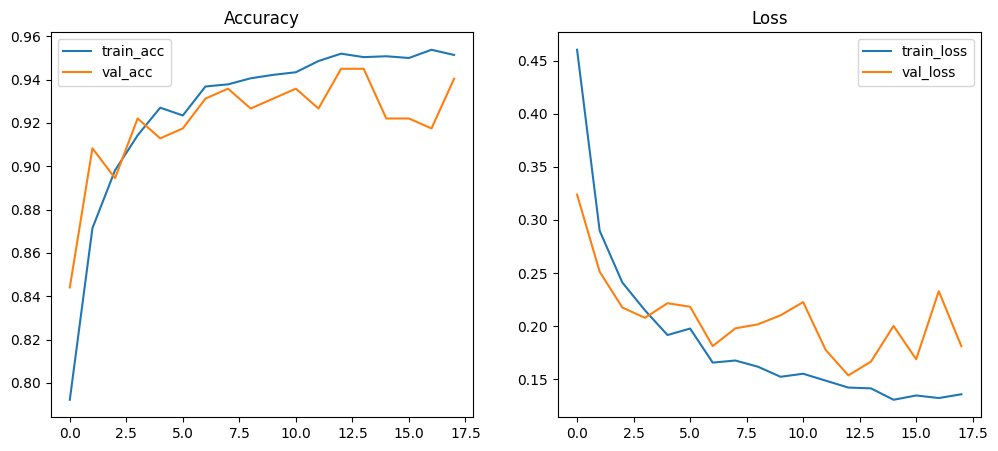

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.show()


In [34]:
test_loss, test_acc, test_recall, test_precision = cnn_model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}, Recall: {test_recall:.4f}, Precision: {test_precision:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 282ms/step - accuracy: 0.7918 - loss: 0.6289 - precision: 0.4672 - recall: 0.6390
Test Accuracy: 0.8738, Recall: 0.9668, Precision: 0.8517


Transfer Learning

In [35]:
# ResNet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(224,224,3))  # Pretrained needs RGB
for layer in base_model.layers:
    layer.trainable = False  # freeze backbone

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(1, activation='sigmoid')(x)

resnet_model = Model(inputs=base_model.input, outputs=preds)
resnet_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [36]:
train_gen_rgb = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), color_mode='rgb',
    batch_size=BATCH_SIZE, class_mode='binary'
)
val_gen_rgb = val_test_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), color_mode='rgb',
    batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)
test_gen_rgb = val_test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), color_mode='rgb',
    batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)

history_resnet = resnet_model.fit(
    train_gen_rgb,
    validation_data=val_gen_rgb,
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Found 5014 images belonging to 2 classes.
Found 218 images belonging to 2 classes.
Found 626 images belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 150s 871ms/step - accuracy: 0.7153 - loss: 0.6527 - precision_1: 0.7555 - recall_1: 0.9263 - val_accuracy: 0.5459 - val_loss: 0.7090 - val_precision_1: 0.5459 - val_recall_1: 1.0000
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 121s 768ms/step - accuracy: 0.7509 - loss: 0.5357 - precision_1: 0.7506 - recall_1: 1.0000 - val_accuracy: 0.5459 - val_loss: 0.6211 - val_precision_1: 0.5459 - val_recall_1: 1.0000
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 118s 751ms/step - accuracy: 0.7506 - loss: 0.5179 - precision_1: 0.7514 - recall_1: 0.9983 - val_accuracy: 0.5459 - val_loss: 0.6703 - val_precision_1: 0.5459 - val_recall_1: 1.0000
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 119s 760ms/step - accuracy: 0.7565 - loss: 0.4584 - precision_1: 0.7590 - recall_1: 0.9883 - val_accuracy: 0.5826 - val_loss: 0.6246 - val_precision_1: 0.5680 - val_recal

In [37]:
for layer in base_model.layers[-30:]:  # last 30 layers
    layer.trainable = True

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                     loss='binary_crossentropy',
                     metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

history_fine = resnet_model.fit(train_gen_rgb, validation_data=val_gen_rgb, epochs=5)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 159s 881ms/step - accuracy: 0.7595 - loss: 0.5252 - precision_2: 0.8370 - recall_2: 0.8297 - val_accuracy: 0.4541 - val_loss: 0.7225 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 120s 758ms/step - accuracy: 0.9028 - loss: 0.2342 - precision_2: 0.9611 - recall_2: 0.9067 - val_accuracy: 0.9128 - val_loss: 0.2718 - val_precision_2: 0.9167 - val_recall_2: 0.9244
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 121s 767ms/step - accuracy: 0.9161 - loss: 0.2016 - precision_2: 0.9641 - recall_2: 0.9226 - val_accuracy: 0.8440 - val_loss: 0.4921 - val_precision_2: 0.7852 - val_recall_2: 0.9832
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 120s 763ms/step - accuracy: 0.9312 - loss: 0.1815 - precision_2: 0.9642 - recall_2: 0.9443 - val_accuracy: 0.8716 - val_loss: 0.2274 - val_precision_2: 0.9892 - val_recall_2: 0.7731
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 141s 760ms/step - accuracy: 0.9259 - loss: 0.1879 - precision_2: 0.96

In [38]:
test_loss, test_acc, test_recall, test_precision = resnet_model.evaluate(test_gen_rgb)
print(f"Transfer Learning Test Accuracy: {test_acc:.4f}, Recall: {test_recall:.4f}, Precision: {test_precision:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 520ms/step - accuracy: 0.6427 - loss: 1.9344 - precision_2: 0.3854 - recall_2: 0.6422
Transfer Learning Test Accuracy: 0.7875, Recall: 0.9770, Precision: 0.7554


In [39]:
import tensorflow as tf
from tensorflow.keras.applications import (
    EfficientNetB0,
    DenseNet121
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Base directories
train_dir = '/content/drive/MyDrive/archive/chest_xray/chest_xray/train'
val_dir   = '/content/drive/MyDrive/archive/chest_xray/chest_xray/val'
test_dir  = '/content/drive/MyDrive/archive/chest_xray/chest_xray/test'

IMG_SIZE = 224    # EfficientNet & DenseNet expect 224×224 RGB
BATCH_SIZE = 32

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), color_mode='rgb',
    batch_size=BATCH_SIZE, class_mode='binary'
)
val_gen = val_test_datagen.flow_from_directory(
    val_dir, target_size=(IMG_SIZE, IMG_SIZE), color_mode='rgb',
    batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)
test_gen = val_test_datagen.flow_from_directory(
    test_dir, target_size=(IMG_SIZE, IMG_SIZE), color_mode='rgb',
    batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)


Found 5014 images belonging to 2 classes.
Found 218 images belonging to 2 classes.
Found 626 images belonging to 2 classes.


EfficientNetB0 Transfer Learning

In [40]:
from tensorflow.keras.applications import EfficientNetB0

# Load base EfficientNetB0
base_eff = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_eff.layers:
    layer.trainable = False   # freeze backbone

# Add custom head
x = base_eff.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid')(x)

eff_model = Model(inputs=base_eff.input, outputs=out)

eff_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

eff_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [41]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/MyDrive/capstone_models/efficientnet_b0.h5', save_best_only=True)
]

history_eff = eff_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.7628 - loss: 0.5662 - precision_3: 0.7664 - recall_3: 0.9927

157/157 ━━━━━━━━━━━━━━━━━━━━ 182s 980ms/step - accuracy: 0.7627 - loss: 0.5663 - precision_3: 0.7663 - recall_3: 0.9927 - val_accuracy: 0.5459 - val_loss: 0.7659 - val_precision_3: 0.5459 - val_recall_3: 1.0000
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.7508 - loss: 0.5692 - precision_3: 0.7508 - recall_3: 1.0000

157/157 ━━━━━━━━━━━━━━━━━━━━ 149s 760ms/step - accuracy: 0.7508 - loss: 0.5692 - precision_3: 0.7508 - recall_3: 1.0000 - val_accuracy: 0.5459 - val_loss: 0.7527 - val_precision_3: 0.5459 - val_recall_3: 1.0000
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.7561 - loss: 0.5647 - precision_3: 0.7561 - recall_3: 1.0000

157/157 ━━━━━━━━━━━━━━━━━━━━ 117s 746ms/step - accuracy: 0.7560 - loss: 0.5647 - precision_3: 0.7560 - recall_3: 1.0000 - val_accuracy: 0.5459 - val_loss: 0.7276 - val_precision_3: 0.5459 - val_recall_3: 1.0000
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 117s 744ms/step - accuracy: 0.7578 - loss: 0.5687 - precision_3: 0.7578 - recall_3: 1.0000 - val_accuracy: 0.5459 - val_loss: 0.7688 - val_precision_3: 0.5459 - val_recall_3: 1.0000
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 116s 736ms/step - accuracy: 0.7547 - loss: 0.5667 - precision_3: 0.7547 - recall_3: 1.0000 - val_accuracy: 0.5459 - val_loss: 0.8024 - val_precision_3: 0.5459 - val_recall_3: 1.0000
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 115s 733ms/step - accuracy: 0.7491 - loss: 0.5695 - precision_3: 0.7491 - recall_3: 1.0000 - val_accuracy: 0.5459 - val_loss: 0.8045 - val_precision_3: 0.5459 - val_recall_3: 1.0000
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 116s 738ms/step - accuracy: 0.7486 - loss: 0.5705 - precision_3: 0.7486 - recall_3:

In [42]:
test_loss, test_acc, test_recall, test_prec = eff_model.evaluate(test_gen)
print(f"EfficientNetB0 Test Accuracy: {test_acc:.4f}, Recall: {test_recall:.4f}, Precision: {test_prec:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 952ms/step - accuracy: 0.2986 - loss: 0.9138 - precision_3: 0.2986 - recall_3: 0.6667
EfficientNetB0 Test Accuracy: 0.6262, Recall: 1.0000, Precision: 0.6262


DenseNet121 Transfer Learning

In [43]:
from tensorflow.keras.applications import DenseNet121

# Load base DenseNet121
base_dense = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_dense.layers:
    layer.trainable = False

# Custom classification head
y = base_dense.output
y = GlobalAveragePooling2D()(y)
y = Dense(256, activation='relu')(y)
y = Dropout(0.5)(y)
out_dense = Dense(1, activation='sigmoid')(y)

dense_model = Model(inputs=base_dense.input, outputs=out_dense)

dense_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

dense_model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [44]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/MyDrive/capstone_models/densenet121.h5', save_best_only=True)
]

history_dense = dense_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - accuracy: 0.8646 - loss: 0.3167 - precision_4: 0.8958 - recall_4: 0.9300

157/157 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.8648 - loss: 0.3162 - precision_4: 0.8960 - recall_4: 0.9301 - val_accuracy: 0.8991 - val_loss: 0.2061 - val_precision_4: 0.8880 - val_recall_4: 0.9328
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.9294 - loss: 0.1752 - precision_4: 0.9533 - recall_4: 0.9515

157/157 ━━━━━━━━━━━━━━━━━━━━ 121s 769ms/step - accuracy: 0.9295 - loss: 0.1751 - precision_4: 0.9533 - recall_4: 0.9515 - val_accuracy: 0.9358 - val_loss: 0.1775 - val_precision_4: 0.9730 - val_recall_4: 0.9076
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 122s 774ms/step - accuracy: 0.9416 - loss: 0.1453 - precision_4: 0.9601 - recall_4: 0.9627 - val_accuracy: 0.9220 - val_loss: 0.2050 - val_precision_4: 1.0000 - val_recall_4: 0.8571
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.9438 - loss: 0.1476 - precision_4: 0.9586 - recall_4: 0.9675

157/157 ━━━━━━━━━━━━━━━━━━━━ 121s 772ms/step - accuracy: 0.9438 - loss: 0.1475 - precision_4: 0.9586 - recall_4: 0.9675 - val_accuracy: 0.9312 - val_loss: 0.1622 - val_precision_4: 0.9561 - val_recall_4: 0.9160
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.9462 - loss: 0.1264 - precision_4: 0.9623 - recall_4: 0.9659

157/157 ━━━━━━━━━━━━━━━━━━━━ 122s 775ms/step - accuracy: 0.9462 - loss: 0.1264 - precision_4: 0.9623 - recall_4: 0.9659 - val_accuracy: 0.9358 - val_loss: 0.1584 - val_precision_4: 0.9200 - val_recall_4: 0.9664
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 120s 764ms/step - accuracy: 0.9538 - loss: 0.1246 - precision_4: 0.9700 - recall_4: 0.9680 - val_accuracy: 0.9128 - val_loss: 0.2063 - val_precision_4: 0.8731 - val_recall_4: 0.9832
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 119s 759ms/step - accuracy: 0.9479 - loss: 0.1272 - precision_4: 0.9613 - recall_4: 0.9693 - val_accuracy: 0.9266 - val_loss: 0.1602 - val_precision_4: 0.9725 - val_recall_4: 0.8908
Epoch 8/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 122s 779ms/step - accuracy: 0.9482 - loss: 0.1343 - precision_4: 0.9672 - recall_4: 0.9645 - val_accuracy: 0.9128 - val_loss: 0.1797 - val_precision_4: 0.9717 - val_recall_4: 0.8655
Epoch 9/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 126s 800ms/step - accuracy: 0.9525 - loss: 0.1205 - precision_4: 0.9674 - recall_4:

157/157 ━━━━━━━━━━━━━━━━━━━━ 124s 790ms/step - accuracy: 0.9525 - loss: 0.1085 - precision_4: 0.9707 - recall_4: 0.9660 - val_accuracy: 0.9312 - val_loss: 0.1430 - val_precision_4: 0.9483 - val_recall_4: 0.9244
Epoch 11/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 123s 785ms/step - accuracy: 0.9562 - loss: 0.1131 - precision_4: 0.9704 - recall_4: 0.9708 - val_accuracy: 0.9220 - val_loss: 0.1798 - val_precision_4: 0.8984 - val_recall_4: 0.9664
Epoch 12/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 121s 768ms/step - accuracy: 0.9563 - loss: 0.1090 - precision_4: 0.9685 - recall_4: 0.9742 - val_accuracy: 0.9312 - val_loss: 0.1457 - val_precision_4: 0.9483 - val_recall_4: 0.9244
Epoch 13/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 121s 774ms/step - accuracy: 0.9599 - loss: 0.1155 - precision_4: 0.9747 - recall_4: 0.9719 - val_accuracy: 0.9266 - val_loss: 0.1475 - val_precision_4: 0.9478 - val_recall_4: 0.9160
Epoch 14/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.9598 - loss: 0.1039 - precision_4: 0.9711 - recall_

157/157 ━━━━━━━━━━━━━━━━━━━━ 121s 773ms/step - accuracy: 0.9598 - loss: 0.1039 - precision_4: 0.9711 - recall_4: 0.9755 - val_accuracy: 0.9404 - val_loss: 0.1411 - val_precision_4: 0.9649 - val_recall_4: 0.9244
Epoch 15/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.9603 - loss: 0.1054 - precision_4: 0.9760 - recall_4: 0.9709

157/157 ━━━━━━━━━━━━━━━━━━━━ 125s 795ms/step - accuracy: 0.9603 - loss: 0.1054 - precision_4: 0.9760 - recall_4: 0.9709 - val_accuracy: 0.9450 - val_loss: 0.1345 - val_precision_4: 0.9350 - val_recall_4: 0.9664


In [45]:
test_loss, test_acc, test_recall, test_prec = dense_model.evaluate(test_gen)
print(f"DenseNet121 Test Accuracy: {test_acc:.4f}, Recall: {test_recall:.4f}, Precision: {test_prec:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 956ms/step - accuracy: 0.8147 - loss: 0.5458 - precision_4: 0.4677 - recall_4: 0.6506
DenseNet121 Test Accuracy: 0.8802, Recall: 0.9796, Precision: 0.8514


20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 929ms/step


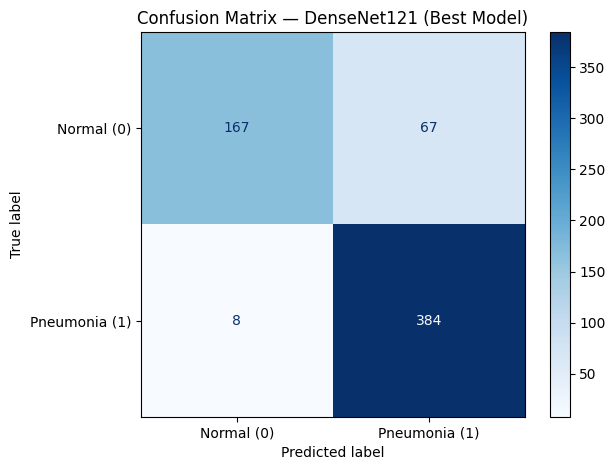

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
y_true = test_gen.classes
y_prob = dense_model.predict(test_gen).ravel()
y_pred = (y_prob >= 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Normal (0)', 'Pneumonia (1)']
)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix — DenseNet121 (Best Model)')
plt.tight_layout()
plt.show()


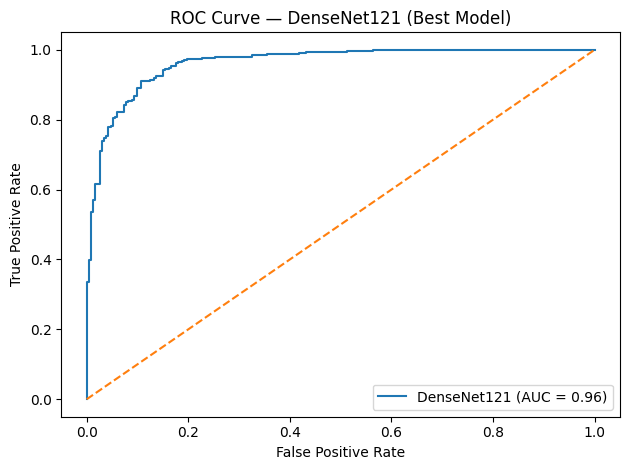

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'DenseNet121 (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — DenseNet121 (Best Model)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()